In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

In [2]:
class StockDataPreTreat():
    def __init__(self):
        self.data_price = pd.read_pickle('E:/SS_data/initial_data/stock_price_standard')
        self.data_market = pd.read_pickle('E:/SS_data/initial_data/stock_valuation_standard')
        self.initial_number_stock = 1410
        self.stock_num = 11
        self.market_num = 10
        self.chunks = 9
        
    def run(self):
        data_dict, data_len_list = self.get_initial_data()
        #筛选裁剪数据集
        #股票筛选
        length = np.array(data_len_list)
        limit = int(np.percentile(length, 18.3))  
        print(f"stock number", self.initial_number_stock*(1-0.183))  
        print(f"time spanner", limit)   
                        #选取81.7%的股票数量（1152只），可裁剪到83.5%的数据长度（2457个）
        self.draw_picture(data_len_list, limit)
        #股票时间序列裁剪
        cut_data_dict = self.cut_data(data_dict, limit)
        #指标计算与数据归一化
        total_dict = self.factor_normalize(cut_data_dict)
        self.save_dict_dataframe(total_dict, 'E:/SS_data/pandas/total_dict')
        #字典切分（为保存减小内存）
        split_dict = self.split_dict_equally(total_dict)
        #滑动窗口采样与数据保存
        for i in range(self.chunks):
            final_data = self.trans_to_torch(split_dict[i])
            path = 'E:/SS_data/torch/total_torch_data'+str(i)
            self.save_torch(final_data, path)
            print(f'完成数据保存:total_torch_data{i}')
            
    def get_initial_data(self):  #拆分数据集
        data_dict = {}
        data_len_list = []
        t = 0
         #拆分总数据，以股票代码划分数据集，并将股票未上市的时间段的nan列剔除
        for i in range(self.initial_number_stock):
            stock = self.data_price.iloc[i*self.stock_num:i* self.stock_num+ self.stock_num,:].dropna(axis=1, how='all')
            market = self.data_market.iloc[i*self.market_num:i*self.market_num+self.market_num,:].dropna(axis=1, how='all')
            common_columns = list(set(stock.columns) & set(market.columns))
            stock_filtered = stock[common_columns]
            market_filtered = market[common_columns]
            data = pd.concat([stock_filtered, market_filtered]).sort_index(axis=1)
            
            stock_index ,index_list = self.index_change(data.index)
            data.index = index_list
            data_dict[stock_index] = data
            data_len = len(data.count())
            data_len_list.append(data_len)
            t += 1
            if t % 200 == 0 and t != 0: 
                print(f"股票拆分完成度: {t / self.initial_number_stock * 100:.2f}%")
        return data_dict, data_len_list
    
    def cut_data(self, data_dict, limit):  #裁剪样本
        cut_data_dict = {}
        for i in data_dict.keys():
            data = data_dict[i]
            if len(data.count())>= limit:
                cut_data_dict[i] = data.iloc[:,:limit]
        return cut_data_dict
    
    def factor_normalize(self, cut_data_dict):  #指标计算与归一化
        total_dict = {}
        t = 0
        for i in list(cut_data_dict.keys()):
            data = cut_data_dict[i].copy()
            data.drop(index=['Pause','FactorPost'], inplace=True)
            new_data = self.Factor_Acquisition(data)
            new_data.replace([np.inf, -np.inf], np.nan, inplace=True)        #将指标计算中的个别除零结果剔除     
            new_data = new_data.apply(lambda row: row.fillna(row.median()), axis=1)     #用中位数填充nan
            data_normalized = new_data.copy()
            data_normalized.iloc[1:,:] = new_data.iloc[1:,:].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1) 
                                     #‘Close’用于强化学习环境计算，不做归一化处理
            total_dict[i] = data_normalized.fillna(0.0) 
            t += 1
            if t % 200 == 0 and t != 0: 
                print(f"指标计算完成度: {t / 1152 * 100:.2f}%")
        return total_dict
    
    def split_dict_equally(self, input_dict):   #字典数据切分
        items = list(input_dict.items())
        chunk_size = len(items) // self.chunks
        extra = len(items) % self.chunks
        return [dict(items[i*chunk_size + min(i, extra):(i+1)*chunk_size + min(i+1, extra)]) for i in range(self.chunks)]
    
    def trans_to_torch(self, split_part):   #字典dataframe转torch.tensor
        torch_list = []
        for i in list(split_part.keys()):
            pandas_data = split_part[i]
            np_data = np.array(pandas_data)
            torch_data = torch.from_numpy(np_data).T
            torch_list.append(torch_data)
        final_data = torch.cat(torch_list, dim=0)
        return final_data
    
    def save_torch(self, data, path):
        torch.save(data, path)
    
    def save_dict_dataframe(self, data_dict, path):
        with open(path, 'wb') as file:
            pickle.dump(data_dict, file)
        
    def index_change(self, index):
        stock_index = index[0][0]
        index_list = []
        for i in range(len(index)):
            index_list.append(index[i][1])
        return stock_index, index_list
    
    def draw_picture(self, data_len_list, limit):
        stock_labels = [a for a in range(1410)]
        plt.figure(figsize=(4, 2)) 
        plt.bar(stock_labels, data_len_list)
        plt.title('Stock Sequence Lengths')
        plt.xlabel('Stocks')
        plt.ylabel('Sequence Length')
        plt.xticks(rotation=90)
        plt.axhline(y=limit, color='r', linestyle='-')
        plt.show()
    
    def Factor_Acquisition(self, data):
        #日收益率
            daily_returns = data.loc['Close'].pct_change()
            data.loc['Daily Return'] = daily_returns
        #对数收益率
            data.loc['Log Return'] = np.log(data.loc['Close'] / data.loc['Close'].shift(1))
        # 5日移动平均线
            ma_5 = data.loc['Close'].rolling(window=5).mean()
            data.loc['MA 5 Days'] = ma_5
        # 10日移动平均线
            ma_10 = data.loc['Close'].rolling(window=10).mean()
            data.loc['MA 10 Days'] = ma_10
        #股价相对均价位置(30日均线)
            moving_average = data.loc['Close'].rolling(window=30).mean()
            data.loc['Position Relative to MA'] = data.loc['Close'] - moving_average
            data.loc['Pct Diff from MA'] = (data.loc['Close'] - moving_average) / moving_average
        # 10日波动率
            volatility = data.loc['Close'].rolling(window=10).std()
            data.loc['10 Day Volatility'] = volatility
        # 30日波动率
            volatility = data.loc['Close'].rolling(window=30).std()
            data.loc['30 Day Volatility'] = volatility
        #RSI相对强弱指数
            delta = data.loc['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            rsi = 100 - (100 / (1 + rs))
            data.loc['RSI'] = rsi
        #移动平均收敛散度（MACD）
            ema10 = data.loc['Close'].ewm(span=10, adjust=False).mean()
            ema30 = data.loc['Close'].ewm(span=30, adjust=False).mean()
            data.loc['DIF'] = ema10 - ema30
            data.loc['DEA'] = data.loc['DIF'].ewm(span=15, adjust=False).mean()
            data.loc['MACD'] = data.loc['DIF'] - data.loc['DEA']
        #心理线指标（PSY）
            period = 20
            data.loc['PSY'] = data.loc['Close'].diff().gt(0).rolling(window=period).sum() / period * 100
        #乖离率(BIAS)
            period = 20
            mean_price = data.loc['Close'].rolling(window=period).mean()
            data.loc['BIAS'] = (data.loc['Close'] - mean_price) / mean_price * 100
        #布林带
            moving_average = data.loc['Close'].rolling(window=20).mean()
            std_dev = data.loc['Close'].rolling(window=20).std()
            data.loc['Upper Band'] = moving_average + (std_dev * 2)
            data.loc['Lower Band'] = moving_average - (std_dev * 2)
        #平均真实范围（ATR）
            high_low = data.loc['High'] - data.loc['Low']
            high_close = np.abs(data.loc['High'] - data.loc['Close'].shift())
            low_close = np.abs(data.loc['Low'] - data.loc['Close'].shift())
            ranges = pd.concat([high_low, high_close, low_close], axis=1)
            true_range = np.max(ranges, axis=1)
            data.loc['ATR'] = true_range.rolling(window=14).mean()
        #成交量加权平均价格（VWAP）
            cumulative_volume_price = (data.loc['Close'] * data.loc['Volume']).cumsum()
            cumulative_volume = data.loc['Volume'].cumsum()
            data.loc['VWAP'] = cumulative_volume_price / cumulative_volume
        #股票收盘价与VWAP的偏离度
            data.loc['VWAP Deviation'] = data.loc['Close'] - data.loc['VWAP']
        #价格变化率(5日)
            data.loc['PriceChange1Week'] = data.loc['Close'].pct_change(periods=5)
        #价格变化率(30日)
            data.loc['PriceChange6Week'] = data.loc['Close'].pct_change(periods=30)
        #成交量变化率(5日)
            data.loc['VolumeChange1Week'] = data.loc['Volume'].pct_change(periods=5)
        #成交量变化率(30日)
            data.loc['VolumeChange6Week'] = data.loc['Volume'].pct_change(periods=30)
        #相对成交量
            average_volume = data.loc['Volume'].rolling(window=20).mean()
            data.loc['RelativeVolume'] = data.loc['Volume'] / average_volume
        #历史最高最低价
            data.loc['Historical High'] = data.loc['Close'].cummax()
            data.loc['Historical Low'] = data.loc['Close'].cummin()
        #股票达到历史最高价以来的天数
            historical_high = data.loc['Historical High']
            data.loc['Days Since High'] = (data.loc['Close'] != historical_high).cumsum()
        #成交额
            data.loc['Turnover'] = data.loc['Volume'] * data.loc['Close']
        #成交量绝对偏差（AACV）
            data.loc['Volume Change'] = data.loc['Volume'].diff()
            data.loc['Avg Abs Volume Change'] = data.loc['Volume Change'].abs().rolling(window=20).mean() 
        #每股收益（EPS）
            data.loc['EPS'] = data.loc['Close'] * data.loc['PeRatio'] 
        #每股净资产
            data.loc['BookValuePerShare'] = data.loc['PBRatio'] * data.loc['Close'] 
        #流通股数量
            data.loc['CirculatingShares'] = data.loc['TurnoverRatio'] * data.loc['Volume'] 
        #每股现金流(CF)
            data.loc['CashFlowPerShare'] = data.loc['PCFRatio'] * data.loc['Close']
        #每股销售收入（SP)
            data.loc['SalesPerShare'] = data.loc['PSRatio'] * data.loc['Close'] 
            return data
        

股票拆分完成度: 14.18%
股票拆分完成度: 28.37%
股票拆分完成度: 42.55%
股票拆分完成度: 56.74%
股票拆分完成度: 70.92%
股票拆分完成度: 85.11%
股票拆分完成度: 99.29%
stock number 1151.97
time spanner 2457


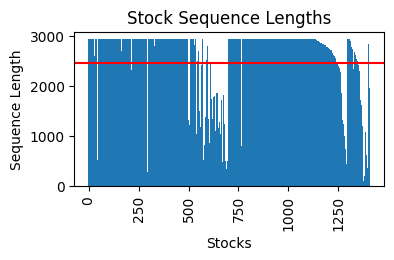

指标计算完成度: 17.36%
指标计算完成度: 34.72%
指标计算完成度: 52.08%
指标计算完成度: 69.44%
指标计算完成度: 86.81%
完成数据保存:total_torch_data0
完成数据保存:total_torch_data1
完成数据保存:total_torch_data2
完成数据保存:total_torch_data3
完成数据保存:total_torch_data4
完成数据保存:total_torch_data5
完成数据保存:total_torch_data6
完成数据保存:total_torch_data7
完成数据保存:total_torch_data8


In [3]:
SDPT = StockDataPreTreat()
SDPT.run()